In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import cv2
import csv
import random
import zipfile
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from functools import reduce
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import ToPILImage
# from linformer import Linformer
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
# from vit_pytorch.efficient import ViT
# from model import BiSeNet
import torchvision.transforms as transforms
from skimage import io, img_as_float
import timm

In [2]:
seed = 17
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [3]:
train_dir_real = '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_real/'
train_dir_fake = '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_fake/'

validation_dir_real = '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/validation_set_real/'
validation_dir_fake = '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/validation_set_fake/'

In [4]:
train_list_real = glob.glob(os.path.join(train_dir_real,'*'))
train_list_fake = glob.glob(os.path.join(train_dir_fake,'*'))

validation_list_real = glob.glob(os.path.join(validation_dir_real,'*'))
validation_list_fake = glob.glob(os.path.join(validation_dir_fake,'*'))

In [5]:
train_list_real = [path.replace('\\','/') for path in train_list_real]
train_list_fake = [path.replace('\\','/') for path in train_list_fake]

validation_list_real = [path.replace('\\','/') for path in validation_list_real]
validation_list_fake = [path.replace('\\','/') for path in validation_list_fake]

In [6]:
all_real_training_images = []
for i in range(len(train_list_real)):
#     print(train_list_real[i])
    for (root, dirs, file) in os.walk(train_list_real[i]):
        for f in file:
            all_real_training_images.append(train_list_real[i] + '/' + f)

                
all_fake_training_images = []
for i in range(len(train_list_fake)):
#     print(train_list_real[i])
    for (root, dirs, file) in os.walk(train_list_fake[i]):
        for f in file:
            all_fake_training_images.append(train_list_fake[i] + '/' + f)

In [7]:
np.random.shuffle(all_real_training_images)                
np.random.shuffle(all_real_training_images)                
np.random.shuffle(all_real_training_images)                

np.random.shuffle(all_fake_training_images)                
np.random.shuffle(all_fake_training_images)                
np.random.shuffle(all_fake_training_images)


all_real_training_images = all_real_training_images[:50000]
all_fake_training_images = all_fake_training_images[:50000]

all_training_images = all_real_training_images
all_training_images.extend(all_fake_training_images)
len(all_training_images)

100000

In [8]:
all_real_validation_images = []

for i in range(len(validation_list_real)):
#     print(train_list_real[i])
    for (root, dirs, file) in os.walk(validation_list_real[i]):
        for f in file:
            all_real_validation_images.append(validation_list_real[i] + '/' + f)               

all_fake_validation_images = []
for i in range(len(validation_list_fake)):
#     print(train_list_real[i])
    for (root, dirs, file) in os.walk(validation_list_fake[i]):
        for f in file:
            all_fake_validation_images.append(validation_list_fake[i] + '/' + f)


In [9]:
np.random.shuffle(all_real_validation_images)                
np.random.shuffle(all_real_validation_images)                
np.random.shuffle(all_real_validation_images)                

np.random.shuffle(all_fake_validation_images)                
np.random.shuffle(all_fake_validation_images)                
np.random.shuffle(all_fake_validation_images)


all_real_validation_images = all_real_validation_images[:10000]
all_fake_validation_images = all_fake_validation_images[:10000]

all_validation_images = all_real_validation_images
all_validation_images.extend(all_fake_validation_images)
len(all_validation_images)

20000

In [10]:
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)

np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)

In [11]:
# all_training_images = all_training_images[:5000]
# all_validation_images = all_validation_images[:1000]


In [12]:
print(f"Training Data: {len(all_training_images)}")
# print(f"Train Data Fake: {len(train_list_fake)}")
print('***********************************')
print('***********************************')
print(f"Validation Data: {len(all_validation_images)}")
# print(f"Validation Data Fake: {len(valid_list_fake)}")

Training Data: 100000
***********************************
***********************************
Validation Data: 20000


In [13]:
all_training_images[:10]

['../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_real/id55_0005/0140.png',
 '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_real/id5_0000/0154.png',
 '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_fake/id31_id1_0002/0015.png',
 '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_real/00162/0143.png',
 '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_real/id31_0008/0058.png',
 '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_fake/id3_id23_0005/0013.png',
 '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_fake/id9_id17_0007/0017.png',
 '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_real/id35_0009/0051.png',
 '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_fake/id29_id21_0003/0013.png',
 '../Datasets/DeepfakeDetection/Celeb-DF-v2/Cleaned_Data/Images/train_set_real/id12_0002

In [14]:
labels = [path.split('/')[-3].split('_')[-1] for path in all_training_images]
print(labels[:10])

['real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real']


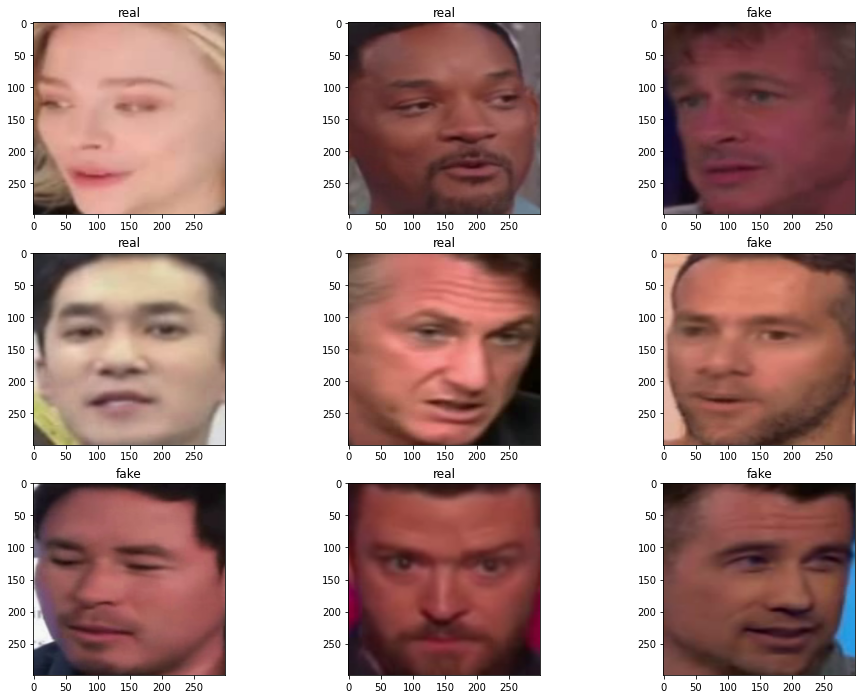

In [15]:
random_idx = np.random.randint(1, len(all_training_images), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
#     frames = sorted(glob.glob(train_list[idx] +'/*.png'))
#     frame = frames[0]
    img = Image.open(all_training_images[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [16]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
        iaa.Resize((224, 224)),
#         iaa.Crop(px=(0, 16)),
        iaa.Fliplr(0.5), # horizontally flip
        iaa.OneOf([
            iaa.Affine(scale=1.5),
            iaa.Affine(rotate=20),
            iaa.Affine(translate_px=(-20, 20)),
            iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=2, size=0.4)
        ]),
#         iaa.OneOf([
#             iaa.JpegCompression(compression=(60, 70)),
#             iaa.GaussianBlur((0, 1.0)),
#             iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.3),
#             iaa.Multiply((0.5, 1.0), per_channel=0.2),
#             iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=1, size=0.5)
#                 ])
        ], random_order=True)
      
    def __call__(self, img):
        img = np.array(img).astype(np.uint8)
        img = self.aug.augment_image(img)
        img = torchvision.transforms.ToTensor()(img)
        img = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
        return img
transforms_imgaug = ImgAugTransform()

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [17]:
import cv2
import dlib
from imutils import face_utils
import imutils
import numpy as np
import torch

def face_remap(shape):
    remapped_image = cv2.convexHull(shape)
    return remapped_image

def augment_face(detector, predictor, img, random_num):
    frame = cv2.imread(img)
#     frame = img
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    out_face = np.zeros_like(frame)
    # out_face = frame
    faces = detector(gray, 1) 
    if not faces:
        pass
    else:
        for face in faces:
            landmarks = predictor(gray, face)
            shape = face_utils.shape_to_np(landmarks)
            remapped_shape = np.zeros_like(shape) 
            feature_mask = np.zeros((frame.shape[0], frame.shape[1]))

        #Lower face
        if random_num == 1:
            remapped_shape = face_remap(shape[1:12])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[3:14])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[6:17])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Eyes and Mouth
        if random_num == 2:
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Eyes, Mouth and Nose
        elif random_num == 3:
            remapped_shape = face_remap(shape[28:36])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Lower left side of face
        elif random_num == 4:
            remapped_shape = face_remap(shape[1:12])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Lower right side of face
        elif random_num == 5:
            remapped_shape = face_remap(shape[6:17])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Nose and Mouth
        elif random_num == 6:
            remapped_shape = face_remap(shape[28:36])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Mouth
        elif random_num == 7:
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        # Eyes and Nose
        elif random_num == 8:
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[28:46])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
        
        
        feature_mask = feature_mask.astype(np.bool)
        out_face[feature_mask] = frame[feature_mask]
        frame = frame - out_face
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         cv2.imwrite("out_face.png", frame)
    
    return frame


In [18]:
class DeepFakeSet(Dataset):
    def __init__(self, file_list, transform=None):

        self.file_list = file_list
        self.transform = transform
        self.to_img = ToPILImage()
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("FaceExtraction/shape_predictor_81_face_landmarks.dat")

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
#         random_num = torch.randint(1, 10, (1,))
#         augmented_face = augment_face(self.detector, self.predictor, img_path, random_num)
#         img_transformed = self.transform(self.to_img(augmented_face))
        img_transformed = self.transform(img)

        label = img_path.split('/')[-3].split('_')[-1]
#         print(label)
        label = 1 if label == "real" else 0
    
        return img_transformed, label

In [19]:
train_data = DeepFakeSet(all_training_images, transform=transforms_imgaug)
valid_data = DeepFakeSet(all_validation_images, transform=val_transforms)

batch_size = 16

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

100000 6250
20000 1250


In [20]:
device = 'cuda'
# device = 'cpu'

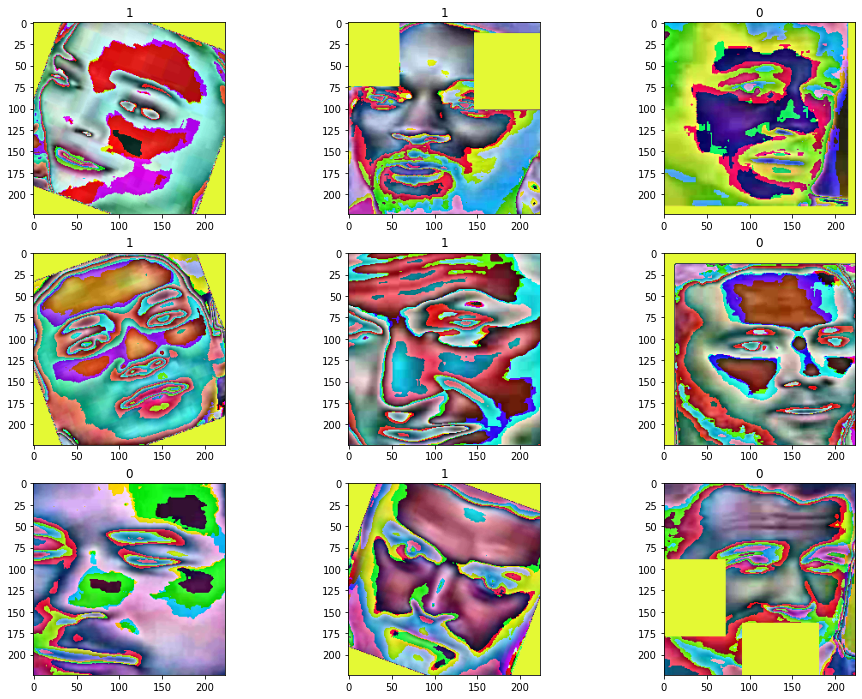

In [21]:
to_img = ToPILImage()

random_idx = np.random.randint(1, len(train_data), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = (to_img(train_data[idx][0]))
    ax.set_title(train_data[idx][1])
    ax.imshow(img)

In [22]:
import timm
models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224', 'mvitv2_base']

augs = ['No_Augmentations', 'Random_Cut_Out_Augs', 'Face_Cut_Out_Augs']
datasets = ['FakeAVCeleb', 'FaceForensics', 'DFDC', 'CelebDFV2']


In [23]:
# CutOut Augs
for model in models:
    
    print("==========================================================================")
    print("==========================================================================")
    print("Training " + model + " on " + datasets[3])
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 5
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            output = net(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
    #             print(data.shape)aa
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        folder_path = ("model_weights/supervised_models/" + model + "/" + augs[1] + '/' + datasets[3] + '/')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()
        
        
    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
            
    print("==========================================================================")
    print("==========================================================================")
    
    

Training xception on CelebDFV2


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.3620 - acc: 0.8309 - val_loss : 0.2221 - val_acc: 0.9098



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1703 - acc: 0.9312 - val_loss : 0.1713 - val_acc: 0.9333



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1195 - acc: 0.9536 - val_loss : 0.1462 - val_acc: 0.9446



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0942 - acc: 0.9641 - val_loss : 0.1375 - val_acc: 0.9490



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0739 - acc: 0.9725 - val_loss : 0.1206 - val_acc: 0.9553

Training res2net101_26w_4s on CelebDFV2


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1655 - acc: 0.9309 - val_loss : 0.1033 - val_acc: 0.9599



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0487 - acc: 0.9819 - val_loss : 0.1034 - val_acc: 0.9610



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0289 - acc: 0.9895 - val_loss : 0.1060 - val_acc: 0.9651



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0226 - acc: 0.9914 - val_loss : 0.0633 - val_acc: 0.9750



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0175 - acc: 0.9941 - val_loss : 0.0767 - val_acc: 0.9719

Training tf_efficientnet_b7_ns on CelebDFV2


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2420 - acc: 0.9014 - val_loss : 0.1718 - val_acc: 0.9289



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0971 - acc: 0.9629 - val_loss : 0.1406 - val_acc: 0.9461



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0621 - acc: 0.9765 - val_loss : 0.1455 - val_acc: 0.9513



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0435 - acc: 0.9839 - val_loss : 0.1157 - val_acc: 0.9581



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0320 - acc: 0.9886 - val_loss : 0.0929 - val_acc: 0.9668

Training vit_base_patch16_224 on CelebDFV2


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2925 - acc: 0.8761 - val_loss : 0.1027 - val_acc: 0.9611



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0405 - acc: 0.9852 - val_loss : 0.0939 - val_acc: 0.9740



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0230 - acc: 0.9915 - val_loss : 0.1045 - val_acc: 0.9652



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0158 - acc: 0.9941 - val_loss : 0.0797 - val_acc: 0.9739



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0131 - acc: 0.9952 - val_loss : 0.1040 - val_acc: 0.9707

Training swin_base_patch4_window7_224 on CelebDFV2


C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2157 - acc: 0.9042 - val_loss : 0.0813 - val_acc: 0.9706



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0656 - acc: 0.9748 - val_loss : 0.0772 - val_acc: 0.9722



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0485 - acc: 0.9813 - val_loss : 0.0741 - val_acc: 0.9760



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0286 - acc: 0.9890 - val_loss : 0.0680 - val_acc: 0.9788



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0708 - acc: 0.9710 - val_loss : 0.0851 - val_acc: 0.9669

Training mvitv2_base on CelebDFV2


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1628 - acc: 0.9286 - val_loss : 0.0477 - val_acc: 0.9814



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0468 - acc: 0.9819 - val_loss : 0.0660 - val_acc: 0.9773



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0309 - acc: 0.9887 - val_loss : 0.0420 - val_acc: 0.9847



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0229 - acc: 0.9915 - val_loss : 0.0690 - val_acc: 0.9779



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0182 - acc: 0.9934 - val_loss : 0.0543 - val_acc: 0.9836



In [23]:
# No Augs
for model in models:
    
    print("==========================================================================")
    print("==========================================================================")
    print("Training " + model + " on " + datasets[3])
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 5
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            output = net(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
    #             print(data.shape)aa
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        folder_path = ("model_weights/supervised_models/" + model + "/" + augs[0] + '/' + datasets[3] + '/')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()
        
        
    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
            
    print("==========================================================================")
    print("==========================================================================")
    
    

Training xception on CelebDFV2


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2540 - acc: 0.8892 - val_loss : 0.2132 - val_acc: 0.9228



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0764 - acc: 0.9721 - val_loss : 0.1766 - val_acc: 0.9389



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0427 - acc: 0.9852 - val_loss : 0.1577 - val_acc: 0.9503



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0274 - acc: 0.9907 - val_loss : 0.1514 - val_acc: 0.9532



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0184 - acc: 0.9942 - val_loss : 0.1466 - val_acc: 0.9577

Training res2net101_26w_4s on CelebDFV2


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0957 - acc: 0.9612 - val_loss : 0.1312 - val_acc: 0.9567



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0129 - acc: 0.9956 - val_loss : 0.0842 - val_acc: 0.9732



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0053 - acc: 0.9982 - val_loss : 0.1263 - val_acc: 0.9652



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0039 - acc: 0.9986 - val_loss : 0.0985 - val_acc: 0.9722



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0038 - acc: 0.9987 - val_loss : 0.1259 - val_acc: 0.9657

Training tf_efficientnet_b7_ns on CelebDFV2


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1523 - acc: 0.9412 - val_loss : 0.2276 - val_acc: 0.9209



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0373 - acc: 0.9862 - val_loss : 0.1691 - val_acc: 0.9442



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0207 - acc: 0.9925 - val_loss : 0.1401 - val_acc: 0.9549



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0110 - acc: 0.9962 - val_loss : 0.1172 - val_acc: 0.9628



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0070 - acc: 0.9977 - val_loss : 0.1160 - val_acc: 0.9643

Training vit_base_patch16_224 on CelebDFV2


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1062 - acc: 0.9636 - val_loss : 0.0854 - val_acc: 0.9670



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0119 - acc: 0.9962 - val_loss : 0.1494 - val_acc: 0.9329



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0051 - acc: 0.9981 - val_loss : 0.0793 - val_acc: 0.9754



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0028 - acc: 0.9990 - val_loss : 0.0549 - val_acc: 0.9824



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0029 - acc: 0.9989 - val_loss : 0.0566 - val_acc: 0.9830

Training swin_base_patch4_window7_224 on CelebDFV2


C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1664 - acc: 0.9278 - val_loss : 0.1005 - val_acc: 0.9633



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0372 - acc: 0.9867 - val_loss : 0.0671 - val_acc: 0.9748



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0209 - acc: 0.9924 - val_loss : 0.0844 - val_acc: 0.9736



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0101 - acc: 0.9966 - val_loss : 0.2295 - val_acc: 0.9309



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0073 - acc: 0.9972 - val_loss : 0.0987 - val_acc: 0.9743

Training mvitv2_base on CelebDFV2


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1207 - acc: 0.9484 - val_loss : 0.0835 - val_acc: 0.9705



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0166 - acc: 0.9939 - val_loss : 0.0963 - val_acc: 0.9711



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0098 - acc: 0.9964 - val_loss : 0.0561 - val_acc: 0.9821



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0056 - acc: 0.9979 - val_loss : 0.0597 - val_acc: 0.9833



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0043 - acc: 0.9986 - val_loss : 0.0789 - val_acc: 0.9794



In [24]:
# No Augs
for model in models:
    
    print("==========================================================================")
    print("==========================================================================")
    print("Training " + model + " on " + datasets[2])
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 5
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            output = net(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
    #             print(data.shape)aa
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        folder_path = ("model_weights/supervised_models/" + model + "/" + augs[0] + '/' + datasets[2] + '/')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()
        
        
    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
            
    print("==========================================================================")
    print("==========================================================================")
    
    

Training xception on DFDC


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.4139 - acc: 0.8016 - val_loss : 0.5550 - val_acc: 0.7386



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1989 - acc: 0.9185 - val_loss : 0.4964 - val_acc: 0.7813



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1374 - acc: 0.9453 - val_loss : 0.4944 - val_acc: 0.7940



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.1062 - acc: 0.9587 - val_loss : 0.5048 - val_acc: 0.8043



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0816 - acc: 0.9689 - val_loss : 0.5152 - val_acc: 0.8103

Training res2net101_26w_4s on DFDC


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2434 - acc: 0.8917 - val_loss : 0.5106 - val_acc: 0.8115



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0890 - acc: 0.9659 - val_loss : 0.4994 - val_acc: 0.8336



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0595 - acc: 0.9768 - val_loss : 0.4956 - val_acc: 0.8472



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0482 - acc: 0.9823 - val_loss : 0.6185 - val_acc: 0.8383



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0363 - acc: 0.9859 - val_loss : 0.6427 - val_acc: 0.8299

Training tf_efficientnet_b7_ns on DFDC


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.3288 - acc: 0.8566 - val_loss : 0.5590 - val_acc: 0.7514



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1392 - acc: 0.9441 - val_loss : 0.5751 - val_acc: 0.7775



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0964 - acc: 0.9623 - val_loss : 0.5286 - val_acc: 0.8023



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0730 - acc: 0.9711 - val_loss : 0.5278 - val_acc: 0.8048



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0586 - acc: 0.9775 - val_loss : 0.5611 - val_acc: 0.8103

Training vit_base_patch16_224 on DFDC


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.4100 - acc: 0.8028 - val_loss : 0.5329 - val_acc: 0.7574



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1218 - acc: 0.9504 - val_loss : 0.4373 - val_acc: 0.8030



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0753 - acc: 0.9698 - val_loss : 0.4444 - val_acc: 0.8170



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0565 - acc: 0.9769 - val_loss : 0.6430 - val_acc: 0.8163



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0443 - acc: 0.9822 - val_loss : 0.4804 - val_acc: 0.8336

Training swin_base_patch4_window7_224 on DFDC


C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.4288 - acc: 0.7853 - val_loss : 0.5097 - val_acc: 0.7499



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.2215 - acc: 0.9045 - val_loss : 0.4814 - val_acc: 0.7665



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1282 - acc: 0.9475 - val_loss : 0.4375 - val_acc: 0.8115



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0925 - acc: 0.9628 - val_loss : 0.4391 - val_acc: 0.8294



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0863 - acc: 0.9658 - val_loss : 0.4929 - val_acc: 0.8113

Training mvitv2_base on DFDC


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2849 - acc: 0.8693 - val_loss : 0.3611 - val_acc: 0.8339



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1081 - acc: 0.9572 - val_loss : 0.3894 - val_acc: 0.8423



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0745 - acc: 0.9701 - val_loss : 0.3354 - val_acc: 0.8622



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0587 - acc: 0.9763 - val_loss : 0.3582 - val_acc: 0.8570



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0484 - acc: 0.9801 - val_loss : 0.3901 - val_acc: 0.8545



# Evaluate on single image

In [26]:
net.eval()


MultiScaleVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (stages): ModuleList(
    (0): MultiScaleVitStage(
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (pool_q): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
            (norm_q): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_k): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_k): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_v): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_v): LayerN

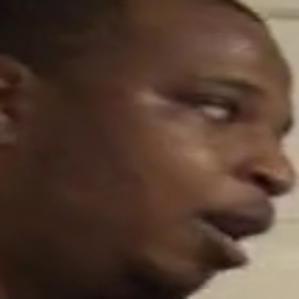

In [46]:
img = Image.open('../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/bfdopzvxbi/0011.png')
img

In [47]:
tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), 
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
img = tfms(img)

In [48]:
labels_map = ["fake", "real"]
# Preprocess image

# Classify

probs = {}
with torch.no_grad():
    outputs = net(img.unsqueeze(0).to(device))
print('-----')
for idx in torch.topk(outputs[0], k=2).indices.tolist():
    prob = torch.softmax(outputs[0], 0)[idx].item()
    probs[idx] = (labels_map[idx], prob*100)
    print((labels_map[idx], prob*100))
#     print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))

-----
('real', 97.11257815361023)
('fake', 2.8874190524220467)


# Evaluate on Videos

In [67]:
videos = sorted(glob.glob('../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/*/'))
videos = [path.replace('\\','/') for path in videos]
len(videos)

200

In [69]:
# model.eval()
labels_map = ["fake", "real"]
count = 0
predictions = {}
probs = {}
for vid in videos:
    count+=1
    print(count)
    fake_prob = 0
    real_prob = 0
#     print(vid)
    images = sorted(glob.glob('../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/'+str(vid.split('/')[-2])+'/*.png'))
    images = [path.replace('\\','/') for path in images]
    if len(images) >= 12:
        for image in images:
            img = Image.open(image)
            tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
            img = tfms(img)
            with torch.no_grad():
                outputs = net(img.unsqueeze(0).to(device))
            for idx in torch.topk(outputs[0], k=1).indices.tolist():
                prob = torch.softmax(outputs[0], 0)[idx].item()
                if labels_map[idx] == 'fake':
                    fake_prob += prob
                    real_prob += 1-prob
                else:
                    real_prob += prob
                    fake_prob += 1 - prob
        if real_prob > fake_prob:
            predictions[vid.split('/')[-2]] = 1
            probs[vid.split('/')[-2]] = (real_prob/len(images))
#             print(image)
#             print('real', real_prob/len(images))
        else:
            predictions[vid.split('/')[-2]] = 0
            probs[vid.split('/')[-2]] = 1-(fake_prob/len(images))
            print(image)
            print('fake', fake_prob/len(images))
    else:
        pass
    print('--------------')
#     break

1
--------------
2
--------------
3
../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/ajiyrjfyzp/0030.png
fake 0.7437748223543167
--------------
4
--------------
5
--------------
6
--------------
7
--------------
8
--------------
9
--------------
10
--------------
11
../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/bkuzquigyt/0030.png
fake 0.6308233559131622
--------------
12
--------------
13
--------------
14
--------------
15
--------------
16
--------------
17
--------------
18
--------------
19
--------------
20
--------------
21
--------------
22
--------------
23
../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/ddtbarpcgo/0030.png
fake 0.7342085152864456
--------------
24
--------------
25
--------------
26
--------------
27
--------------
28
--------------
29
--------------
30
--------------
31
--------------
32
--------------
33
--------------
34
../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/dxfd

In [64]:
# model.eval()
labels_map = ["fake", "real"]
count = 0
predictions = {}
probs = {}
for vid in videos:
    count+=1
    print(count)
    fake_prob = 0
    real_prob = 0
#     print(vid)
    images = sorted(glob.glob('../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/'+str(vid.split('/')[-2])+'/*.png'))
    images = [path.replace('\\','/') for path in images]
    if len(images) >= 12:
        for image in images:
            img = Image.open(image)
            tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
            img = tfms(img)
            with torch.no_grad():
                outputs = net(img.unsqueeze(0).to(device))
            for idx in torch.topk(outputs[0], k=1).indices.tolist():
                prob = torch.softmax(outputs[0], 0)[idx].item()
                if labels_map[idx] == 'fake':
                    fake_prob += prob
                    real_prob += 1-prob
                else:
                    real_prob += prob
                    fake_prob += 1 - prob
        if real_prob > fake_prob:
            predictions[vid.split('/')[-2]] = 1
            probs[vid.split('/')[-2]] = (real_prob/len(images))
#             print(image)
#             print('real', real_prob/len(images))
        else:
            predictions[vid.split('/')[-2]] = 0
            probs[vid.split('/')[-2]] = 1-(fake_prob/len(images))
            print(image)
            print('fake', fake_prob/len(images))
    else:
        pass
    print('--------------')
#     break

1
--------------
2
--------------
3
../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/ajiyrjfyzp/0030.png
fake 0.7437748223543167
--------------
4
--------------
5
--------------
6
--------------
7
--------------
8
--------------
9
--------------
10
--------------
11
../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/bkuzquigyt/0030.png
fake 0.6308233559131622
--------------
12
--------------
13
--------------
14
--------------
15
--------------
16
--------------
17
--------------
18
--------------
19
--------------
20
--------------
21
--------------
22
--------------
23
../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/ddtbarpcgo/0030.png
fake 0.7342085152864456
--------------
24
--------------
25
--------------
26
--------------
27
--------------
28
--------------
29
--------------
30
--------------
31
--------------
32
--------------
33
--------------
34
../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/dxfd

KeyboardInterrupt: 

'aayfryxljh'

# Write results to CSV

In [23]:
with open(folder_path + 'results.csv', 'w') as csvfile:
    fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

    writer.writeheader()
    for i in range(len(validation_accuracies)):
        writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
    

# Model Parameter Count

In [54]:
models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224', 'xcit_medium_24_p16_224', 'cait_s24_224']

net = timm.create_model(models[6], pretrained=True, num_classes=2)

In [40]:
# XCEPTION
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

21.0

In [43]:
# Res2Net 101
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

43.0

In [45]:
# Efficient Net B7
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

64.0

In [47]:
# ViT Base
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

86.0

In [49]:
# Swin Base
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

87.0

In [53]:
# XCIT Medium
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

84.0

In [55]:
# CAIT S
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

47.0